In [1]:
# -- driver_run_forecast_LV2_v1.py  --
# master python script to do a full LV2 forecast simulation

import sys
import pickle
import numpy as np
import os
from datetime import datetime
import gc
import resource
import subprocess
import netCDF4 as nc
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator, LinearNDInterpolator,interp1d


##############

sys.path.append('../sdpm_py_util')

import atm_functions as atmfuns
import ocn_functions as ocnfuns
import grid_functions as grdfuns
import plotting_functions as pltfuns
from get_PFM_info import get_PFM_info
from init_funs import initialize_simulation
from make_LV1_dotin_and_SLURM import make_LV1_dotin_and_SLURM
from run_slurm_LV1 import run_slurm_LV1

level = 2

/home/mspydell/models/PFM_root/PFM/driver/../sdpm_py_util/ocn_functions.py:24: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater


In [2]:
# need to run the LV1 simulation to make LV1_his.nc
# and get the raw hycom and atm data.  
cmd_list = ['python','-W','ignore','driver_run_forecast_LV1_v4.py']
ret1 = subprocess.run(cmd_list)     



Starting the LV1 simulation, Current time  2024-09-03 10:27:56.005566
we are going to start clean...
getting PFM info...
PFM info was loaded from /scratch/PFM_Simulations/PFM_run_info.pkl
removing PFM info file...
now removing all input files...
PFM info was saved as /scratch/PFM_Simulations/PFM_run_info.pkl
Starting: driver_run_forecast_LV1
Current local Time = 2024-09-03 10:27:56.055520 UTC =  2024-09-03 17:27:56.055524+00:00  Fetch time =  2024-09-02 12:00:00

Preparing forecast starting on 20240902 at  1200
ocean boundary and initial conditions will be from:
hycom
atm forcing will be from:
nam_nest

Getting OCN forecast data. Going to use subprocess, and save a pickle file of ocn data.
PFM info was loaded from /scratch/PFM_Simulations/PFM_run_info.pkl
in the parallel ncks switch
Time to get full file using parallel ncks = 972.66 sec
Return code = 0 (0=success, 1=skipped ncks)

max and min raw hycom data (iz is top [0] to bottom [39]):
max zeta   =  0.375 m          at  ( it, ilat,

In [3]:
PFM=get_PFM_info()


LV1_IC_pckl = PFM['lv1_forc_dir'] + '/' + PFM['lv1_ocnIC_tmp_pckl_file']

with open(LV1_IC_pckl,'rb') as fout:
    IC1=pickle.load(fout)
    print('LV1 OCN_IC dict loaded with pickle')

print(IC1.keys())



PFM info was loaded from /scratch/PFM_Simulations/PFM_run_info.pkl
LV1 OCN_IC dict loaded with pickle
dict_keys(['ocean_time', 'lat_rho', 'lon_rho', 'lat_u', 'lon_u', 'lat_v', 'lon_v', 'ocean_time_ref', 'zeta', 'Nz', 'Vtr', 'Vst', 'th_s', 'th_b', 'Tcl', 'hc', 'temp', 'salt', 'u', 'v', 'ubar', 'vbar', 'vinfo', 'Cs_r'])


In [4]:
# putting atm raw data on to the roms LV2 grid
t1 = datetime.now()
# put the atm data on the roms grid, and rotate the velocities
# everything in this dict turn into the atm.nc file
print('in atmfuns.get_atm_data_on_roms_grid(ATM,RMG)')
print('doing level: ' + str(level))
cmd_list = ['python','-W','ignore','atm_functions.py','get_atm_data_on_roms_grid',str(level)]
os.chdir('../sdpm_py_util')
ret5 = subprocess.run(cmd_list)   
print('return code: ' + str(ret5.returncode) + ' (0=good)')  
os.chdir('../sdpm_py_util')
print('done with: atmfuns.get_atm_data_on_roms_grid(ATM,RMG)')
# all the fields plotted with the data on roms grid
t2 = datetime.now()
print('this took:')
print(t2-t1)
print('\n')



in atmfuns.get_atm_data_on_roms_grid(ATM,RMG)
doing level: 2
PFM info was loaded from /scratch/PFM_Simulations/PFM_run_info.pkl

ATM on roms grid dict saved with pickle.
return code: 0 (0=good)
done with: atmfuns.get_atm_data_on_roms_grid(ATM,RMG)
this took:
0:00:01.755195




In [5]:
# plot both raw and LV2 atm fields
t1 = datetime.now()
plot_all_atm = 1
if plot_all_atm == 1:
    print('plotting atm and atm on roms grid...')
    pltfuns.plot_all_fields_in_one(str(level))
    print('...done with: pltfuns.plot_all_fields_in_one')

t2 = datetime.now()
print('this took:')
print(t2-t1)
print('\n')


plotting atm and atm on roms grid...
PFM info was loaded from /scratch/PFM_Simulations/PFM_run_info.pkl
...done with: pltfuns.plot_all_fields_in_one
this took:
0:00:09.968420




<Figure size 640x480 with 0 Axes>

In [6]:
# save the atm data into LV2_atm.nc
print('driver_run_forcast_LV2: saving LV2_ATM.nc file')
#atmfuns.atm_roms_dict_to_netcdf(str(level))
os.chdir('../sdpm_py_util')
ret5 = subprocess.run(cmd_list)   
cmd_list = ['python','-W','ignore','atm_functions.py','atm_roms_dict_to_netcdf',str(level)]
print('return code: ' + str(ret5.returncode) + ' (0=good)')  
os.chdir('../sdpm_py_util')
print('driver_run_forecast_L21:  done with writing LV2_ATM.nc file.') 
# put in a function to plot the atm.nc file if we want to


driver_run_forcast_LV2: saving LV2_ATM.nc file
PFM info was loaded from /scratch/PFM_Simulations/PFM_run_info.pkl
return code: 0 (0=good)
driver_run_forecast_L21:  done with writing LV2_ATM.nc file.


In [7]:
print('driver_run_forcast_LV2: saving LV2_OCN_BC pickle file')
os.chdir('../sdpm_py_util')
cmd_list = ['python','-W','ignore','ocn_functions.py','mk_LV2_BC_dict']
ret5 = subprocess.run(cmd_list)   
print('return code: ' + str(ret5.returncode) + ' (0=good)')  
os.chdir('../sdpm_py_util')
print('driver_run_forecast_L21:  done with writing LV2_OCN_BC.pkl file.') 


PFM info was loaded from /scratch/PFM_Simulations/PFM_run_info.pkl
OCN_LV1_BC dict loaded with pickle
OCN_LV2_BC dict saved with pickle


In [8]:
lv2_ocnBC_pckl = PFM['lv2_forc_dir'] + '/' + PFM['lv2_ocnBC_tmp_pckl_file']
lv2_bc_file_out = PFM['lv2_forc_dir'] + '/' + PFM['lv2_bc_file']

print('driver_run_forcast_LV2: saving LV2_OCN_BC netcdf file')
os.chdir('../sdpm_py_util')
cmd_list = ['python','-W','ignore','ocn_functions.py','ocn_roms_BC_dict_to_netcdf_pckl',lv2_ocnBC_pckl,lv2_bc_file_out]
ret5 = subprocess.run(cmd_list)   
print('return code: ' + str(ret5.returncode) + ' (0=good)')  
os.chdir('../sdpm_py_util')
print('driver_run_forecast_L21:  done with writing LV2_OCN_BC.nc file.') 


fn_pckl = PFM['lv1_forc_dir'] + '/' + PFM['lv1_ocn_tmp_pckl_file']
ocnBC_pckl = PFM['lv1_forc_dir'] + '/' + PFM['lv1_ocnBC_tmp_pckl_file']
fn_atm_out = PFM['lv1_forc_dir'] + '/' + PFM['lv1_atm_file'] # LV1 atm forcing filename


OCN_BC dict loaded with pickle

max and min of data in ROMS BC file (iz is bottom [0] to top [39]):
max zeta_north =  0.771 m          at  ( it, ilon)     =  ( 41, 155)
min zeta_north = -0.686 m          at  ( it, ilon)     =  ( 48,   0)
max zeta_south =  0.803 m          at  ( it, ilon)     =  ( 41, 137)
min zeta_south = -0.604 m          at  ( it, ilon)     =  ( 48, 247)
max zeta_west  =  0.768 m          at  ( it, ilat)     =  ( 41,   0)
min zeta_west  = -0.686 m          at  ( it, ilat)     =  ( 48, 397)
max ubar_north =  0.060 m/s        at  ( it, ilon)     =  ( 34,  42)
min ubar_north = -0.087 m/s        at  ( it, ilon)     =  ( 52,  54)
max ubar_south =  0.060 m/s        at  ( it, ilon)     =  ( 36,  15)
min ubar_south = -0.042 m/s        at  ( it, ilon)     =  ( 48, 228)
max ubar_west  =  0.100 m/s        at  ( it, ilat)     =  ( 60,  11)
min ubar_west  = -0.096 m/s        at  ( it, ilat)     =  ( 43, 368)
max vbar_north =  0.184 m/s        at  ( it, ilon)     =  ( 52,  26)
min

In [2]:
print('driver_run_forcast_LV2: saving LV2_OCN_IC pickle file')
os.chdir('../sdpm_py_util')
cmd_list = ['python','-W','ignore','ocn_functions.py','mk_LV2_IC_dict']
ret5 = subprocess.run(cmd_list)   
print('return code: ' + str(ret5.returncode) + ' (0=good)')  
os.chdir('../sdpm_py_util')
print('driver_run_forecast_L21:  done with writing LV2_OCN_IC.pkl file.') 


PFM info was loaded from /scratch/PFM_Simulations/PFM_run_info.pkl
LV1 OCN_IC dict loaded with pickle
OCN_LV2_IC dict saved with pickle


In [3]:
lv2_ocnIC_pckl = PFM['lv2_forc_dir'] + '/' + PFM['lv2_ocnIC_tmp_pckl_file']
lv2_ic_file_out = PFM['lv2_forc_dir'] + '/' + PFM['lv2_ini_file']

ocnfuns.ocn_roms_IC_dict_to_netcdf_pckl(fname_in,fn_out)

OCN_IC dict loaded with pickle

max and min of data in ROMS IC file (iz is bottom [0] to top [39], note: it is always 0 b/c IC):
max zeta   =  0.175 m          at  ( it, ilat, ilon)     =  (  0,  53, 164)
min zeta   =  0.042 m          at  ( it, ilat, ilon)     =  (  0, 197,   8)
max ubar   =  0.143 m/s        at  ( it, ilat, ilon)     =  (  0, 143,  48)
min ubar   = -0.083 m/s        at  ( it, ilat, ilon)     =  (  0, 371,  60)
max vbar   =  0.156 m/s        at  ( it, ilat, ilon)     =  (  0, 165, 137)
min vbar   = -0.089 m/s        at  ( it, ilat, ilon)     =  (  0, 225, 212)
max u      =  0.243 m/s        at  ( it, iz, ilat, ilon) =  (  0, 30, 152,   9)
min u      = -0.302 m/s        at  ( it, iz, ilat, ilon) =  (  0, 35, 308,  54)
max v      =  0.336 m/s        at  ( it, iz, ilat, ilon) =  (  0, 33, 240, 128)
min v      = -0.179 m/s        at  ( it, iz, ilat, ilon) =  (  0, 39, 375, 155)
max temp   = 23.542 C          at  ( it, iz, ilat, ilon) =  (  0, 39, 224, 251)
min temp   =  2

In [4]:


PFM=get_PFM_info()
G1 = grdfuns.roms_grid_to_dict(PFM['lv1_grid_file'])
G2 = grdfuns.roms_grid_to_dict(PFM['lv2_grid_file'])

fn = PFM['lv1_his_name_full']
his_ds = nc.Dataset(fn)

#vrn = 'vbar'
#zz = his_ds.variables[vrn][0,:,:]
#zz = G1['angle']

print(G1.keys())


PFM info was loaded from /scratch/PFM_Simulations/PFM_run_info.pkl
dict_keys(['lon_rho', 'lat_rho', 'lon_u', 'lat_u', 'lon_v', 'lat_v', 'h', 'mask_rho', 'mask_u', 'mask_v', 'angle', 'angle_u', 'angle_v', 'Nz', 'Vtransform', 'Vstretching', 'THETA_S', 'THETA_B', 'TCLINE', 'hc'])


1.0
0.0
17453
81217.0


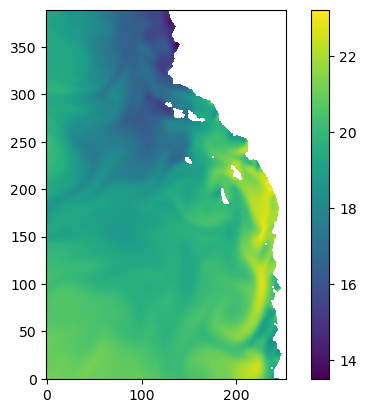

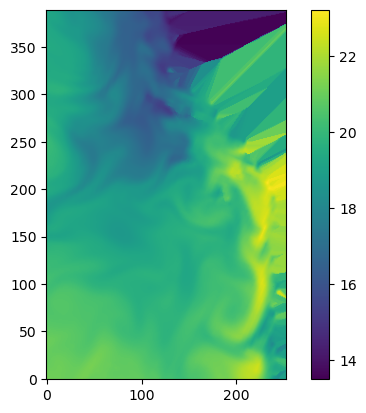

In [3]:

#print(G1['mask_rho'][-1,:])
gr_msk = G1['mask_rho']
print(gr_msk[0,0])
print(gr_msk[-1,-1])
aa = ocnfuns.get_indices_to_fill(G1['mask_rho'])

vrn = 'temp'
zz = np.squeeze(his_ds.variables[vrn][0,-1,:,:])
zz2 = zz.copy()
zz2[gr_msk==0] = zz2[gr_msk==1][aa]

print(len(aa))
print(np.sum(gr_msk))

fig, ax = plt.subplots()
pos=ax.imshow(zz ,origin='lower')
fig.colorbar(pos,ax=ax)

fig, ax = plt.subplots()
pos=ax.imshow(zz2,origin='lower')
fig.colorbar(pos,ax=ax)


In [ ]:

lt1 = his_ds.variables['lat_rho'][:]
ln1 = his_ds.variables['lon_rho'][:]
#print(np.shape(ln1))
M, L = np.shape(ln1) # M = nlat, L = nlon

lt2 = G2['lat_rho']
ln2 = G2['lon_rho']

print(np.shape(lt2))
print(np.shape(lt1))

xr1,yr1 = ocnfuns.ll2xy(ln1, lt1, np.mean(ln1), np.mean(lt1))
xr2,yr2 = ocnfuns.ll2xy(ln2, lt2, np.mean(ln1), np.mean(lt1))


if vrn == 'zeta':
    zz[zz==0] = np.nan
    
#zzf = ocnfuns.extrap_nearest_to_masked(xr1, yr1, zz, fld0=0)
zzf = zz

# set up stuff for interpolating...

X_ind, Y_ind = np.meshgrid(np.arange(L),np.arange(M))

#print(np.shape(X_ind))

parent_points = np.zeros((M*L,2))
parent_points[:,1] = xr1.flatten()
parent_points[:,0] = yr1.flatten()

xi_values = X_ind.flatten()
scat_interp_xi = LinearNDInterpolator(parent_points,xi_values)

eta_values = Y_ind.flatten()
scat_interp_eta = LinearNDInterpolator(parent_points,eta_values)

XI_child = scat_interp_xi(yr2,xr2)
ETA_child = scat_interp_eta(yr2,xr2)

xi_n = XI_child[-1,:]
xi_s = XI_child[0,:]
xi_w  = XI_child[:,0]
eta_n = ETA_child[-1,:]
eta_s = ETA_child[0,:]
eta_w  = ETA_child[:,0]

print(np.shape(lt2))
print(np.shape(XI_child))

interper = RegularGridInterpolator( (np.arange(M), np.arange(L)), np.squeeze(zzf) )
zzfi = interper((ETA_child,XI_child))

zz_n = interper((eta_n,xi_n))

print(np.shape(zzfi))

print(np.size(zz_n))

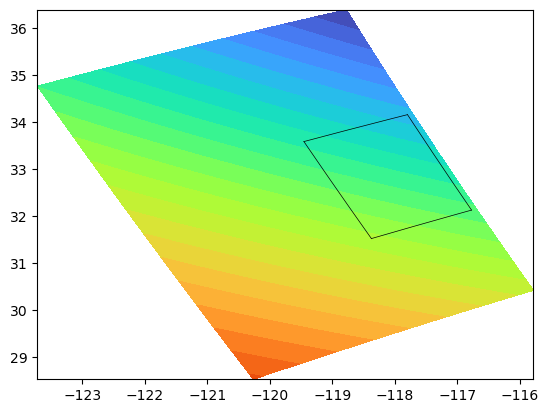

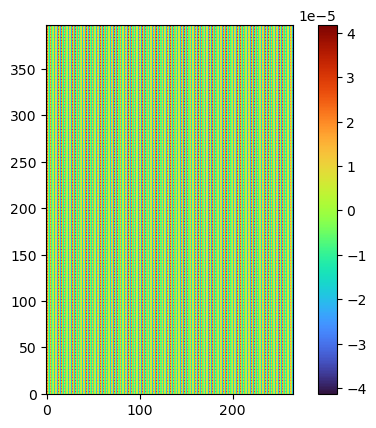

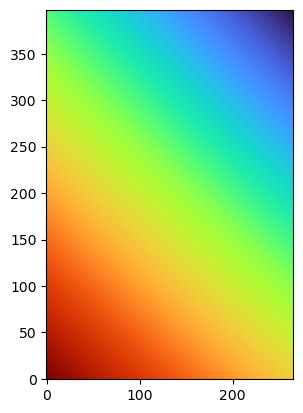

In [67]:


fig, ax = plt.subplots()
lvs = np.arange(.35,.5,.005)
ax.contourf(ln1, lt1, zzf, lvs )
ax.contourf(ln2, lt2, G2['angle'], lvs )
pltfuns.plot_roms_box(ax, G2)

fig, ax = plt.subplots()
pos=ax.imshow(G2['angle'] - zzfi ,origin='lower')
fig.colorbar(pos,ax=ax)

fig, ax = plt.subplots()
ax.imshow(zzfi,origin='lower')


In [ ]:


# now making history file plots
print('now making LV1 history file plots')
pltfuns.make_all_his_figures('LV1')
